In [1]:
from __future__ import print_function

import os
from copy import deepcopy

import keras
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
'''
***** Set parameters *****
'''
seed = 99
noise_level = 0
clean_data_size = 200
learning_rate = 0.001

n = 2
depth = n * 9 + 2

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

np.set_printoptions(threshold=np.inf)

np.random.seed(seed)
tf.set_random_seed(seed)

'''
***** Load data *****
'''
# Load the CIFAR10 data.
(x_train_, y_train_), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
num_classes = 10
y_train_ = keras.utils.to_categorical(y_train_, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Input image dimensions.
input_shape = x_train_.shape[1:]

# Normalize data.
x_train_ = x_train_.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Subtract pixel mean is enabled
x_train_mean = np.mean(x_train_, axis=0)
x_train_ -= x_train_mean
x_test -= x_train_mean

# Seperate validation set
x_validation = x_train_[0:10000, ]
y_validation = y_train_[0:10000, ]
x_train = x_train_[10000:50000, ]
y_train = y_train_[10000:50000, ]

# Generate clean dataset
clean_index = []
for i in range(10):
    positive_index = list(np.where(y_train[:, i] == 1)[0])
    clean_index = np.append(clean_index, np.random.choice(positive_index, clean_data_size, replace=False)).astype(
        int)

x_clean = x_train[clean_index]
y_clean = y_train[clean_index]
x_train = np.delete(x_train, clean_index, axis=0)
y_train = np.delete(y_train, clean_index, axis=0)
y_train_orig = deepcopy(y_train)

# Add additional data
add_number = []
file = open('additional_data_index1.txt')
lines = file.readlines()
precision = '['
for line in lines:
    precision += line.replace('\n', '').replace(' ', ',')
precision += ']'
precision = eval(
    precision.replace('][', '], [').replace(',,,,', ',').replace(',,,', ',').replace(',,', ',').replace('[,', '['))

for label in range(10):
    add_number.append(len(precision[label]))
bootstrap_size = min(add_number)

In [3]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = learning_rate
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, lr=lr_schedule(0), num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2  # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=lr),
                  metrics=['accuracy'])
    return model

Learning rate:  0.001


In [14]:
model = resnet_v2(input_shape, depth)
student_dir = 'saved_models/student_model_partial_data/'
files = os.listdir(student_dir)
for file in files:
    model.load_weights(student_dir+file)
    print(file)
    print(model.evaluate(x_test, y_test))

cifar10_hard_noise_0.5_threshold_0.8__file0.h5
10000/10000 [==============================] - 4s 442us/step
[1.5784954147338868, 0.6435]
cifar10_soft_noise_0.5_threshold_0.7__file0.h5
10000/10000 [==============================] - 2s 230us/step
[1.2469719038009643, 0.6392]
cifar10_hard_noise_0.5_threshold_0.6__file0.h5
10000/10000 [==============================] - 2s 246us/step
[1.876717318725586, 0.6351]
cifar10_soft_noise_0.9_threshold_0.8__file0.h5
10000/10000 [==============================] - 2s 243us/step
[1.3982920476913452, 0.6185]
cifar10_soft_noise_0.3_threshold_0.7__file0.h5
10000/10000 [==============================] - 2s 241us/step
[1.194892548942566, 0.6505]
cifar10_soft_noise_0.5_threshold_0.8__file0.h5
10000/10000 [==============================] - 3s 251us/step
[1.2497607548713685, 0.6485]
cifar10_hard_noise_0.9_threshold_0.6__file0.h5
10000/10000 [==============================] - 2s 242us/step
[1.4826212305068969, 0.6426]
cifar10_soft_high_all_noise_0.5_threshold_0

In [4]:
"""
# Generate model.
"""
model = resnet_v2(input_shape, depth)
for index in range(1):
    file_path = 'saved_models/teacher_model_bagging1/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    print(model.evaluate(x_test, y_test))

10000/10000 [==============================] - 3s 298us/step
[2.394968570137024, 0.6228]


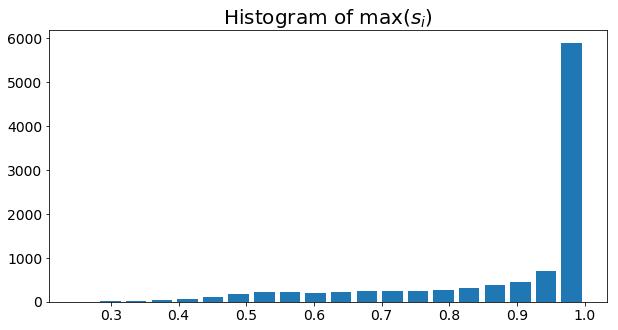

0.6228
0.7601170160897124
0.7318492652407973
0.6994998076183148
0.6743553347527798
0.656688390588755


In [21]:
import matplotlib.pyplot as plt

model = resnet_v2(input_shape, depth)
file_path = 'saved_models/teacher_model_bagging1/cifar10_file0.h5'
model.load_weights(file_path)
acc = model.predict(x_test)
acc_max = np.max(acc, axis=1)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc, axis=1)==np.argmax(y_test, axis=1)))
data_index = np.where(acc>0.95)
print(np.mean(np.argmax(acc[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc>0.9)
print(np.mean(np.argmax(acc[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc>0.8)
print(np.mean(np.argmax(acc[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc>0.7)
print(np.mean(np.argmax(acc[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc>0.6)
print(np.mean(np.argmax(acc[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))

(10000,) (10000, 10)


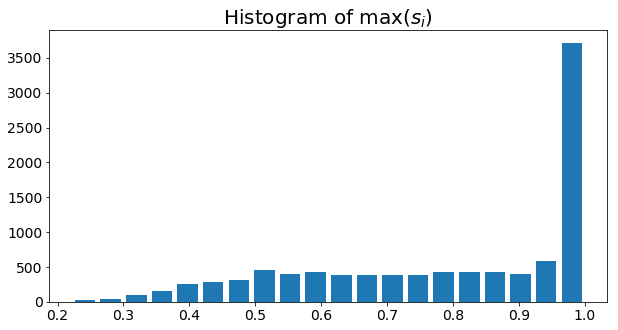

0.66
0.8871297242083759
3916
0.8655665566556656
4545
0.829160007103534
5631
0.7870328680774425
6663
0.7512392381946256
7666


In [23]:
import matplotlib.pyplot as plt

n = 5
acc = np.zeros([n, 10000, 10])
model = resnet_v2(input_shape, depth)
for index in range(n):
    file_path = 'saved_models/teacher_model_bagging1/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    acc[index] = model.predict(x_test)
acc_mean = np.mean(acc, axis=0)
acc_max = np.max(acc_mean, axis=1)
print(acc_max.shape, acc_mean.shape)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc_mean, axis=1)==np.argmax(y_test, axis=1)))
data_index = np.where(acc_max>0.95)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.9)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.8)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.7)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.6)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
print(len(data_index[0]))

(38000,) (38000, 10)


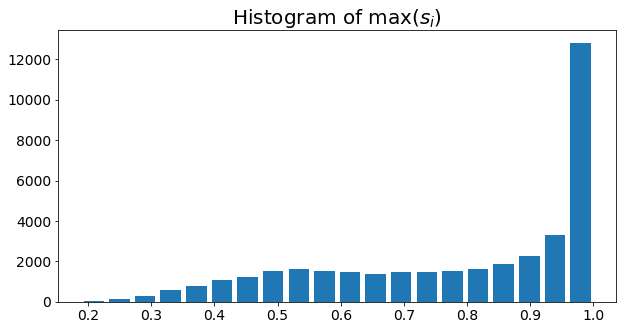

0.6608157894736842
0.9164239953407105
13736
0.8803824978267168
17255
0.8290107872389259
21785
0.7899446603084893
25479
0.7520342021790097
29004


In [11]:
import matplotlib.pyplot as plt

n = 20
acc = np.zeros([n, 38000, 10])
model = resnet_v2(input_shape, depth)
for index in range(n):
    file_path = 'saved_models/teacher_model_bagging1/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    acc[index] = model.predict(x_train)
acc_mean = np.mean(acc, axis=0)
acc_max = np.max(acc_mean, axis=1)
print(acc_max.shape, acc_mean.shape)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc_mean, axis=1)==np.argmax(y_train, axis=1)))
data_index = np.where(acc_max>0.95)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.9)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.8)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.7)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.6)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))

(38000,) (38000, 10)


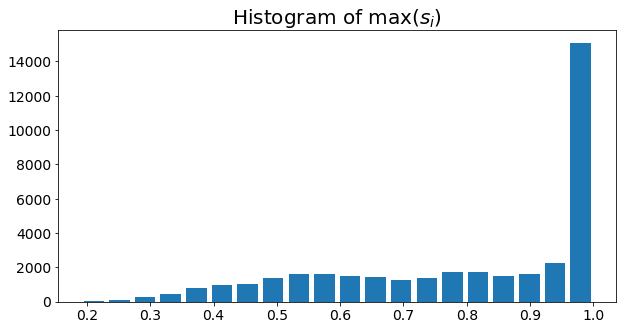

0.6610263157894737
0.8839438765792648
15751
0.8622075419763281
18165
0.8216787958233512
22123
0.78354493883379
25913
0.7469617760879896
29458


In [10]:
import matplotlib.pyplot as plt

n = 5
acc = np.zeros([n, 38000, 10])
model = resnet_v2(input_shape, depth)
for index in range(n):
    file_path = 'saved_models/teacher_model_bagging1/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    acc[index] = model.predict(x_train)
acc_mean = np.mean(acc, axis=0)
acc_max = np.max(acc_mean, axis=1)
print(acc_max.shape, acc_mean.shape)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc_mean, axis=1)==np.argmax(y_train, axis=1)))
data_index = np.where(acc_max>0.95)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.9)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.8)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.7)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))
data_index = np.where(acc_max>0.6)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_train[data_index[0]], axis=1)))
print(len(data_index[0]))

(10000,) (10000, 10)


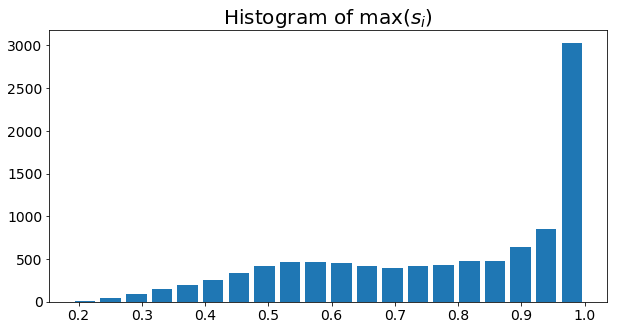

0.6541
0.8762222752206058
0.9124042879019908


In [8]:
import matplotlib.pyplot as plt

acc = np.zeros([20, 10000, 10])
for index in range(20):
    file_path = 'saved_models/teacher_model_bagging2/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    acc[index] = model.predict(x_test)
acc_mean = np.mean(acc, axis=0)
acc_max = np.max(acc_mean, axis=1)
print(acc_max.shape, acc_mean.shape)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc_mean, axis=1)==np.argmax(y_test, axis=1)))
data_index = np.where(acc_max>0.9)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc_max>0.95)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))

In [14]:
a = np.arange(20)
print(np.where(a>10)[0])
print(np.where((a>10) & (a<15))[0])

[11 12 13 14 15 16 17 18 19]
[11 12 13 14]


In [1]:
model = resnet_v2(input_shape, depth)
for index in range(20):
    file_path = 'saved_models/teacher_model_bagging2/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    print(model.evaluate(x_test, y_test))

NameError: name 'resnet_v2' is not defined

(10000,) (10000, 10)


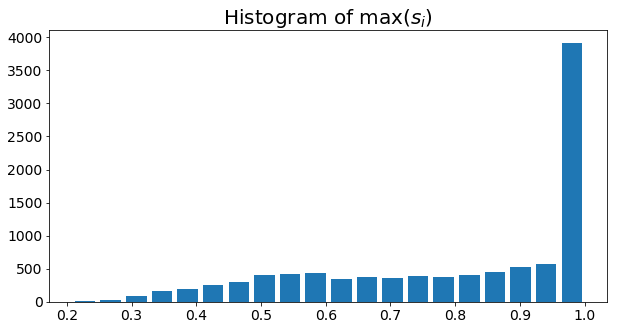

0.67
0.876
0.8978639823226123


In [31]:
import matplotlib.pyplot as plt

acc = np.zeros([9, 10000, 10])
for index in range(9):
    file_path = 'saved_models/teacher_model_bagging/cifar10_file%d.h5'%index
    model.load_weights(file_path)
    acc[index] = model.predict(x_test)
acc_mean = np.mean(acc, axis=0)
acc_max = np.max(acc_mean, axis=1)
print(acc_max.shape, acc_mean.shape)

plt.figure(figsize=(10, 5))
plt.hist(acc_max, bins=20, rwidth=0.8)
plt.title('Histogram of max($s_i$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(np.mean(np.argmax(acc_mean, axis=1)==np.argmax(y_test, axis=1)))
data_index = np.where(acc_max>0.9)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))
data_index = np.where(acc_max>0.95)
print(np.mean(np.argmax(acc_mean[data_index[0]], axis=1)==np.argmax(y_test[data_index[0]], axis=1)))